In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/nowplayingrs/sentiment_values.csv
/kaggle/input/nowplayingrs/user_track_hashtag_timestamp.csv
/kaggle/input/nowplayingrs/context_content_features.csv


In [0]:
# Set your project id here
PROJECT_ID = 'module4-Project'

from google.cloud import bigquery
client = bigquery.Client(project=PROJECT_ID, location="US")

## OBSERVER & SCRUB: Understand the Datasets and Prepare the Data
* Load 3 datasets: sentiment_values.csv, user_track_hashtag_timestamp.csv and context_content_features.csv
* Data type conversions (e.g. numeric data mistakenly encoded as objects)
* Detect and deal with missing values
* Remove unnecessary columns

In [0]:
df = pd.read_csv('../input/nowplayingrs/sentiment_values.csv')

#Look at size of the dataset
df.shape

(5290, 17)

In [0]:
#Look at the columns and initial rows of the dataset
df.head()

,,,,hashtag,vader_min,vader_max,vader_sum,vader_avg,afinn_min,afinn_max,afinn_sum,afinn_avg,ol_min,ol_max,ol_sum,ol_avg,ss_min,ss_max,ss_sum,ss_avg
relaxtime,0.8,0.8,2.4,0.8,NaN,NaN,NaN,NaN,0.7375,0.7375,0.7375,0.7375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
melovechilicheese,0.8,0.8,0.8,0.8,NaN,NaN,NaN,NaN,0.9000,0.9000,0.9000,0.9000,1.0,1.0,1.0,1.0,0.8,0.8,0.8,0.8
greatmusic,0.8,0.8,2.4,0.8,1.0,1.0,1.0,1.0,0.8875,0.8875,0.8875,0.8875,1.0,1.0,1.0,1.0,0.8,0.8,0.8,0.8
rockballad,0.7,0.7,0.7,0.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amonamarth,0.3,0.3,0.3,0.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


In [0]:
#Rename hashtag column
df.rename(columns = {'hashtag':'ss_score'}, inplace = True)

#Reset index
df.reset_index(inplace=True)

#Rename columns
df.rename(columns = {'level_0':'hashtag','level_1':'vader_score','level_2':'afinn_score','level_3':'ol_score'}, inplace = True)

#Show dataset to confirm changes
df.head()

,hashtag,vader_score,afinn_score,ol_score,ss_score,vader_min,vader_max,vader_sum,vader_avg,afinn_min,...,afinn_sum,afinn_avg,ol_min,ol_max,ol_sum,ol_avg,ss_min,ss_max,ss_sum,ss_avg
0,relaxtime,0.8,0.8,2.4,0.8,NaN,NaN,NaN,NaN,0.7375,...,0.7375,0.7375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,melovechilicheese,0.8,0.8,0.8,0.8,NaN,NaN,NaN,NaN,0.9000,...,0.9000,0.9000,1.0,1.0,1.0,1.0,0.8,0.8,0.8,0.8
2,greatmusic,0.8,0.8,2.4,0.8,1.0,1.0,1.0,1.0,0.8875,...,0.8875,0.8875,1.0,1.0,1.0,1.0,0.8,0.8,0.8,0.8
3,rockballad,0.7,0.7,0.7,0.7,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,amonamarth,0.3,0.3,0.3,0.3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


In [0]:
#Set columns
df.columns=['hashtag','vader_score','afinn_score','ol_score','ss_score','vader_min','vader_max','vader_sum','vader_avg','afinn_min',
            'afinn_max','afinn_sum','afinn_avg','ol_min','ol_max','ol_sum','ol_avg','ss_min','ss_max','ss_sum','ss_avg']

The following 12 columns are unecessary and will be removed from the data set:

- **vader_min**: no valuable information, will use vader_score instead
- **vader_max**: no valuable information, will use vader_score instead
- **vader_sum**: no valuable information, will use vader_score instead
- **affin_min**: no valuable information, will use affin_score instead
- **affin_max**: no valuable information, will use affin_score instead
- **affin_sum**: no valuable information, will use affin_score instead
- **ol_min**: no valuable information, will use ol_score instead
- **ol_max**: no valuable information, will use ol_score instead
- **ol_sum**: no valuable information, will use ol_score instead
- **ss_min**: no valuable information, will use ss_score instead
- **ss_max**: no valuable information, will use ss_score instead
- **ss_sum**: no valuable information, will use ss_score instead

In [0]:
df = df.drop(['vader_min','vader_max','vader_sum','afinn_min','afinn_max','afinn_sum','ol_min','ol_max','ol_sum','ss_min','ss_max','ss_sum'], axis=1)
df.head()

,hashtag,vader_score,afinn_score,ol_score,ss_score,vader_avg,afinn_avg,ol_avg,ss_avg
0,relaxtime,0.8,0.8,2.4,0.8,NaN,0.7375,NaN,NaN
1,melovechilicheese,0.8,0.8,0.8,0.8,NaN,0.9000,1.0,0.8
2,greatmusic,0.8,0.8,2.4,0.8,1.0,0.8875,1.0,0.8
3,rockballad,0.7,0.7,0.7,0.7,NaN,NaN,NaN,NaN
4,amonamarth,0.3,0.3,0.3,0.3,NaN,NaN,0.0,NaN


In [0]:
#Show how many (sum) unique values are in the hashtag column
len(df['hashtag'].unique().tolist())

5290

In [0]:
df.info()
#There all score columns are missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 9 columns):
hashtag        5290 non-null object
vader_score    3867 non-null float64
afinn_score    3867 non-null float64
ol_score       3867 non-null float64
ss_score       3867 non-null float64
vader_avg      255 non-null float64
afinn_avg      2635 non-null float64
ol_avg         2823 non-null float64
ss_avg         2160 non-null float64
dtypes: float64(8), object(1)
memory usage: 372.1+ KB


In [0]:
#Fill in missing vader_score with vader_avg score, if available
df['vader_score'] = df.apply(
    lambda row: row['vader_avg'] if np.isnan(row['vader_score']) else row['vader_score'],
    axis=1
)

In [0]:
df.info()
#vader_score didn't change

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 9 columns):
hashtag        5290 non-null object
vader_score    3871 non-null float64
afinn_score    3867 non-null float64
ol_score       3867 non-null float64
ss_score       3867 non-null float64
vader_avg      255 non-null float64
afinn_avg      2635 non-null float64
ol_avg         2823 non-null float64
ss_avg         2160 non-null float64
dtypes: float64(8), object(1)
memory usage: 372.1+ KB


In [0]:
#Fill in missing afinn_score with afinn_avg score, if available
df['afinn_score'] = df.apply(
    lambda row: row['afinn_avg'] if np.isnan(row['afinn_score']) else row['afinn_score'],
    axis=1
)

In [0]:
df.info()
#afinn_score increased from 3867 to 4532

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 9 columns):
hashtag        5290 non-null object
vader_score    3871 non-null float64
afinn_score    4532 non-null float64
ol_score       3867 non-null float64
ss_score       3867 non-null float64
vader_avg      255 non-null float64
afinn_avg      2635 non-null float64
ol_avg         2823 non-null float64
ss_avg         2160 non-null float64
dtypes: float64(8), object(1)
memory usage: 372.1+ KB


In [0]:
#Fill in missing ol_score with ol_avg score, if available
df['ol_score'] = df.apply(
    lambda row: row['ol_avg'] if np.isnan(row['ol_score']) else row['ol_score'],
    axis=1
)

In [0]:
df.info()
#ol_score increased from 3867 to 4831

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 9 columns):
hashtag        5290 non-null object
vader_score    3871 non-null float64
afinn_score    4532 non-null float64
ol_score       4831 non-null float64
ss_score       3867 non-null float64
vader_avg      255 non-null float64
afinn_avg      2635 non-null float64
ol_avg         2823 non-null float64
ss_avg         2160 non-null float64
dtypes: float64(8), object(1)
memory usage: 372.1+ KB


In [0]:
#Fill in missing ss_score with ss_avg score, if available
df['ss_score'] = df.apply(
    lambda row: row['ss_avg'] if np.isnan(row['ss_score']) else row['ss_score'],
    axis=1
)

In [0]:
df.info()
#ss_score increased from 3867 to 4471

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 9 columns):
hashtag        5290 non-null object
vader_score    3871 non-null float64
afinn_score    4532 non-null float64
ol_score       4831 non-null float64
ss_score       4471 non-null float64
vader_avg      255 non-null float64
afinn_avg      2635 non-null float64
ol_avg         2823 non-null float64
ss_avg         2160 non-null float64
dtypes: float64(8), object(1)
memory usage: 372.1+ KB


In [0]:
#Remove all of the unnecessary scores - ol_score has the highest amount of ratings per hashtag
df1 = df.drop(['vader_score','afinn_score','ss_score','vader_avg','afinn_avg','ol_avg','ss_avg'], axis=1)
df1.head()

,hashtag,ol_score
0,relaxtime,2.4
1,melovechilicheese,0.8
2,greatmusic,2.4
3,rockballad,0.7
4,amonamarth,0.3


In [0]:
df1 = df1.dropna(axis = 0, how ='any') 
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4831 entries, 0 to 5289
Data columns (total 2 columns):
hashtag     4831 non-null object
ol_score    4831 non-null float64
dtypes: float64(1), object(1)
memory usage: 113.2+ KB


In [0]:
df1.sort_index(by='hashtag', ascending=[False])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  """Entry point for launching an IPython kernel.


,hashtag,ol_score
1118,zerofucks,0.2
556,zappa,0.0
2467,zapetlone,0.3
2565,zapateando,0.0
1963,youwontbemissed,0.3
713,yousomuchrightnow,1.0
3892,youshockme,0.2
4808,yourwelcome,0.7
785,yoursavior,1.0
2136,yourfriendlystation,0.7


In [0]:
#Rename column
df1.rename(columns = {'ol_score':'sentiment_score'}, inplace = True)
df1.head()

,hashtag,sentiment_score
0,relaxtime,2.4
1,melovechilicheese,0.8
2,greatmusic,2.4
3,rockballad,0.7
4,amonamarth,0.3


## Load the second dataset
* Remove null values
* Remove tracks that were played less than 10 times
* Merge it with the cleaned df1 dataset

In [0]:
#Load second dataset
df2 = pd.read_csv('../input/nowplayingrs/user_track_hashtag_timestamp.csv')

#Look at size of the dataset
df2.shape

(17560113, 4)

In [0]:
#Look at the columns and initial rows of the dataset
df2.head()

,user_id,track_id,hashtag,created_at
0,81496937,cd52b3e5b51da29e5893dba82a418a4b,nowplaying,2014-01-01 05:54:21
1,81496937,cd52b3e5b51da29e5893dba82a418a4b,goth,2014-01-01 05:54:21
2,81496937,cd52b3e5b51da29e5893dba82a418a4b,deathrock,2014-01-01 05:54:21
3,81496937,cd52b3e5b51da29e5893dba82a418a4b,postpunk,2014-01-01 05:54:21
4,2205686924,da3110a77b724072b08f231c9d6f7534,NowPlaying,2014-01-01 05:54:22


In [0]:
#Check for null values
df2.apply(lambda x: x.isnull().sum())

user_id       0
track_id      0
hashtag       1
created_at    0
dtype: int64

In [0]:
#Drop null rows
df2.dropna(subset=['hashtag'], inplace=True)
df2.apply(lambda x: x.isnull().sum())

user_id       0
track_id      0
hashtag       0
created_at    0
dtype: int64

In [0]:
# Get the count of the track_id
counts = df2['track_id'].value_counts()

# Select the items where the track_id count is less than 10 and remove them
df2 = df2[~df2['track_id'].isin(counts[counts < 10].index)]

# Show info
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16873184 entries, 0 to 17560112
Data columns (total 4 columns):
user_id       int64
track_id      object
hashtag       object
created_at    object
dtypes: int64(1), object(3)
memory usage: 643.7+ MB


In [0]:
#Merge CSV files into a single file based on hashtag
df_sentiment = pd.merge(df1, df2, on="hashtag", how='inner')
df_sentiment.head()

,hashtag,sentiment_score,user_id,track_id,created_at
0,relaxtime,2.4,104415394,9175ac1532ee7dbe97602866efabac58,2014-05-20 07:24:40
1,relaxtime,2.4,240771401,c2da30eb3450e8a3e5bfa16e8fa527da,2014-10-12 22:46:57
2,relaxtime,2.4,637256774,dcbb5aff8f96a79be9f59bc0e7b5c38d,2014-11-07 13:01:08
3,melovechilicheese,0.8,2438833016,76ed33b994cc15575614b91284b965bb,2014-05-05 23:58:21
4,greatmusic,2.4,252330820,8f2ac86abb8bd48273c8fc95b632e347,2014-02-13 16:18:51


In [0]:
#Confirm null values in new dataframe
df_sentiment.apply(lambda x: x.isnull().sum())

hashtag            0
sentiment_score    0
user_id            0
track_id           0
created_at         0
dtype: int64

In [0]:
df_sentiment.shape

(5804133, 5)

Now that the two CSV files are joined (inner join), the new dataframe `df_sentiment` is reduced to **5,804,133** rows (from 17,560,114).

## Load the third dataset
* Remove tracks that were played less than 10 times
* Remove unnecessary columns
* Remove null values
* Reduce the dataset to English only language
* Merge it with the df_sentiment dataset based on `track_id`, `created_at` and `user_id` columns

In [0]:
#Load third dataset and limit it to only load 22 columns
df3 = pd.read_csv('../input/nowplayingrs/context_content_features.csv', usecols=range(0, 22))

#Look at size of the dataset
df3.shape

(11614671, 22)

In [0]:
# Get the count of the track_id
counts = df3['track_id'].value_counts()

# Select the items where the track_id count is less than 10 and remove them
df3 = df3[~df3['track_id'].isin(counts[counts < 10].index)]

# Show info
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10887911 entries, 0 to 11614670
Data columns (total 22 columns):
coordinates         object
instrumentalness    float64
liveness            float64
speechiness         float64
danceability        float64
valence             float64
loudness            float64
tempo               float64
acousticness        float64
energy              float64
mode                float64
key                 float64
artist_id           object
place               object
geo                 object
tweet_lang          object
track_id            object
created_at          object
lang                object
time_zone           object
user_id             float64
id                  int64
dtypes: float64(12), int64(1), object(9)
memory usage: 1.9+ GB


By removing tracks that were played less than 10 times, the dataset is reduced from 11,614,671 to **10,887,911** rows. The following unnecessary columns will be droped:

- **coordinates**: no valuable information, will use `time_zone` instead
- **id**: no valuable information, will use `user_id instead
- **place**: no valuable information, will use `time_zone` instead
- **geo**: no valuable information, will use `time_zone` instead

In [0]:
#Drop unnecessary columns before merging with df_sentiment dataframe
df3 = df3.drop(['coordinates','id','place','geo'], axis=1)
df3.head()

,instrumentalness,liveness,speechiness,danceability,valence,loudness,tempo,acousticness,energy,mode,key,artist_id,tweet_lang,track_id,created_at,lang,time_zone,user_id
0,0.00479,0.1800,0.0294,0.634,0.342,-8.345,125.044,0.00035,0.697,1.0,6.0,b2980c722a1ace7a30303718ce5491d8,en,cd52b3e5b51da29e5893dba82a418a4b,2014-01-01 05:54:21,en,Central Time (US & Canada),8.149694e+07
1,0.01770,0.0638,0.0624,0.769,0.752,-8.252,95.862,0.26700,0.826,1.0,7.0,5cddcd0e314e2f2223ab21937d2c8778,en,da3110a77b724072b08f231c9d6f7534,2014-01-01 05:54:22,en,NaN,2.205687e+09
2,0.00000,0.0860,0.0436,0.675,0.775,-4.432,97.030,0.21700,0.885,0.0,1.0,e41273f43af504714d85465294f1f369,en,ba84d88c10fb0e42d4754a27ead10546,2014-01-01 05:54:22,es,Mountain Time (US & Canada),1.325884e+08
3,0.00000,0.1430,0.0292,0.324,0.333,-5.647,74.101,0.23900,0.574,1.0,7.0,557ce373bd29743eb00a3723ab19ebe8,en,33f95122281f76e7134f9cbea3be980f,2014-01-01 05:54:24,en,Eastern Time (US & Canada),9.767522e+07
5,0.00000,0.1100,0.0375,0.641,0.912,-4.271,93.010,0.02680,0.787,1.0,0.0,f965ec352eb8c0efc0af46244754942f,en,8bd5206b84c968eda0af8bc86d6ab1d1,2014-01-01 05:54:25,en,Central Time (US & Canada),4.522857e+08


In [0]:
#Drop all null value rows
df3 = df3.dropna()

#Convert mode to Int64
df3['mode'] = df3['mode'].astype('Int64')

df3.shape

(7740906, 18)

Reduced the dataset from 10,887,911 to **7,740,906** by dropping all null value rows.

In [0]:
#Limit dataset to only en (English) language
df3 = df3.loc[~((df3['lang'] != 'en')),:]
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5879570 entries, 0 to 11614670
Data columns (total 18 columns):
instrumentalness    float64
liveness            float64
speechiness         float64
danceability        float64
valence             float64
loudness            float64
tempo               float64
acousticness        float64
energy              float64
mode                float64
key                 float64
artist_id           object
tweet_lang          object
track_id            object
created_at          object
lang                object
time_zone           object
user_id             float64
dtypes: float64(12), object(6)
memory usage: 852.3+ MB


In [0]:
#Confirm change by looking at the unique values in the lang column
df3.lang.unique()

array(['en'], dtype=object)

Reduced the dataset from 7,740,906 to **5,879,570** by limited it to English only (lang = en).

In [0]:
#Merge df_sentiment and df3 CSV files into new CSV file based on track_id and created_at
df4 = df_sentiment.merge(df3, on=['track_id','created_at','user_id'], how='inner')
df4.head()

,hashtag,sentiment_score,user_id,track_id,created_at,instrumentalness,liveness,speechiness,danceability,valence,loudness,tempo,acousticness,energy,mode,key,artist_id,tweet_lang,lang,time_zone
0,greatmusic,2.4,252330820,8f2ac86abb8bd48273c8fc95b632e347,2014-02-13 16:18:51,0.00000,0.1980,0.1690,0.461,0.502,-9.046,143.055,0.1000,0.628,0,4.0,1a17d5f8af99355edd8a92679a02cb0d,en,en,Eastern Time (US & Canada)
1,greatmusic,2.4,29235188,45bbd6d7cd65dc77596af8c5c0b89a70,2014-05-15 20:38:46,0.00001,0.0454,0.0451,0.677,0.886,-13.237,77.837,0.0313,0.544,0,11.0,4a4e2ab094a4521b06252e9fdaf1fd0a,en,en,Eastern Time (US & Canada)
2,nowplaying,0.6,29235188,45bbd6d7cd65dc77596af8c5c0b89a70,2014-05-15 20:38:46,0.00001,0.0454,0.0451,0.677,0.886,-13.237,77.837,0.0313,0.544,0,11.0,4a4e2ab094a4521b06252e9fdaf1fd0a,en,en,Eastern Time (US & Canada)
3,classic,1.0,29235188,45bbd6d7cd65dc77596af8c5c0b89a70,2014-05-15 20:38:46,0.00001,0.0454,0.0451,0.677,0.886,-13.237,77.837,0.0313,0.544,0,11.0,4a4e2ab094a4521b06252e9fdaf1fd0a,en,en,Eastern Time (US & Canada)
4,greatmusic,2.4,324650101,e3d0a3cc327c3f163cf4c3aebd3f5091,2014-05-22 16:56:59,0.84100,0.1290,0.4770,0.584,0.223,-31.865,131.831,0.9270,0.103,0,0.0,c026548b7fa4b1f772f2f59374b93bba,en,en,Eastern Time (US & Canada)


In [0]:
#Convert hashtag info string
df4['hashtag'] = df4['hashtag'].astype(str)

#Convert user_id info string
df4['user_id'] = df4['user_id'].astype(str)

#Show changes
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3671884 entries, 0 to 3671883
Data columns (total 20 columns):
hashtag             object
sentiment_score     float64
user_id             object
track_id            object
created_at          object
instrumentalness    float64
liveness            float64
speechiness         float64
danceability        float64
valence             float64
loudness            float64
tempo               float64
acousticness        float64
energy              float64
mode                Int64
key                 float64
artist_id           object
tweet_lang          object
lang                object
time_zone           object
dtypes: Int64(1), float64(11), object(8)
memory usage: 591.8+ MB


In [0]:
#Create new column sentiment that will be the predictor based on the sentiment_score values
df4['sentiment'] = np.where(df4['sentiment_score']>= 0.01, 1, 0)
df4.head()

,hashtag,sentiment_score,user_id,track_id,created_at,instrumentalness,liveness,speechiness,danceability,valence,...,tempo,acousticness,energy,mode,key,artist_id,tweet_lang,lang,time_zone,sentiment
0,greatmusic,2.4,252330820,8f2ac86abb8bd48273c8fc95b632e347,2014-02-13 16:18:51,0.00000,0.1980,0.1690,0.461,0.502,...,143.055,0.1000,0.628,0,4.0,1a17d5f8af99355edd8a92679a02cb0d,en,en,Eastern Time (US & Canada),1
1,greatmusic,2.4,29235188,45bbd6d7cd65dc77596af8c5c0b89a70,2014-05-15 20:38:46,0.00001,0.0454,0.0451,0.677,0.886,...,77.837,0.0313,0.544,0,11.0,4a4e2ab094a4521b06252e9fdaf1fd0a,en,en,Eastern Time (US & Canada),1
2,nowplaying,0.6,29235188,45bbd6d7cd65dc77596af8c5c0b89a70,2014-05-15 20:38:46,0.00001,0.0454,0.0451,0.677,0.886,...,77.837,0.0313,0.544,0,11.0,4a4e2ab094a4521b06252e9fdaf1fd0a,en,en,Eastern Time (US & Canada),1
3,classic,1.0,29235188,45bbd6d7cd65dc77596af8c5c0b89a70,2014-05-15 20:38:46,0.00001,0.0454,0.0451,0.677,0.886,...,77.837,0.0313,0.544,0,11.0,4a4e2ab094a4521b06252e9fdaf1fd0a,en,en,Eastern Time (US & Canada),1
4,greatmusic,2.4,324650101,e3d0a3cc327c3f163cf4c3aebd3f5091,2014-05-22 16:56:59,0.84100,0.1290,0.4770,0.584,0.223,...,131.831,0.9270,0.103,0,0.0,c026548b7fa4b1f772f2f59374b93bba,en,en,Eastern Time (US & Canada),1


In [0]:
#Drop all null value rows
df4 = df4.dropna()

#Drop unnecessary columns lang and created_at
df4 = df4.drop(['lang','created_at'], axis=1)

df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3671884 entries, 0 to 3671883
Data columns (total 19 columns):
hashtag             object
sentiment_score     float64
user_id             object
track_id            object
instrumentalness    float64
liveness            float64
speechiness         float64
danceability        float64
valence             float64
loudness            float64
tempo               float64
acousticness        float64
energy              float64
mode                Int64
key                 float64
artist_id           object
tweet_lang          object
time_zone           object
sentiment           int64
dtypes: Int64(1), float64(11), int64(1), object(6)
memory usage: 563.8+ MB


In [0]:
# Reorder columns
df_mvp = df4[['hashtag','user_id','track_id','artist_id','tweet_lang','time_zone','sentiment','sentiment_score','instrumentalness',
              'liveness','speechiness','danceability','valence','loudness','tempo','acousticness','energy','mode','key']]
df_mvp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3671884 entries, 0 to 3671883
Data columns (total 19 columns):
hashtag             object
user_id             object
track_id            object
artist_id           object
tweet_lang          object
time_zone           object
sentiment           int64
sentiment_score     float64
instrumentalness    float64
liveness            float64
speechiness         float64
danceability        float64
valence             float64
loudness            float64
tempo               float64
acousticness        float64
energy              float64
mode                Int64
key                 float64
dtypes: Int64(1), float64(11), int64(1), object(6)
memory usage: 563.8+ MB


## Explore the data

* Look at the distribution for the data
* Look for multicolinarity
* Remove unnecessary features

In [0]:
#Look at value counts of the predictor variable sentiment
df_mvp.sentiment.value_counts()

1    3620609
0      51275
Name: sentiment, dtype: int64

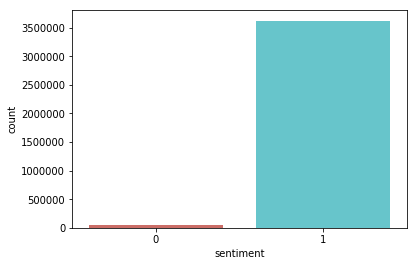

In [0]:
# Visualize the predictor variable
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='sentiment', data=df_mvp, palette='hls')
plt.show()

**Observation**: The data is very imbalanced.

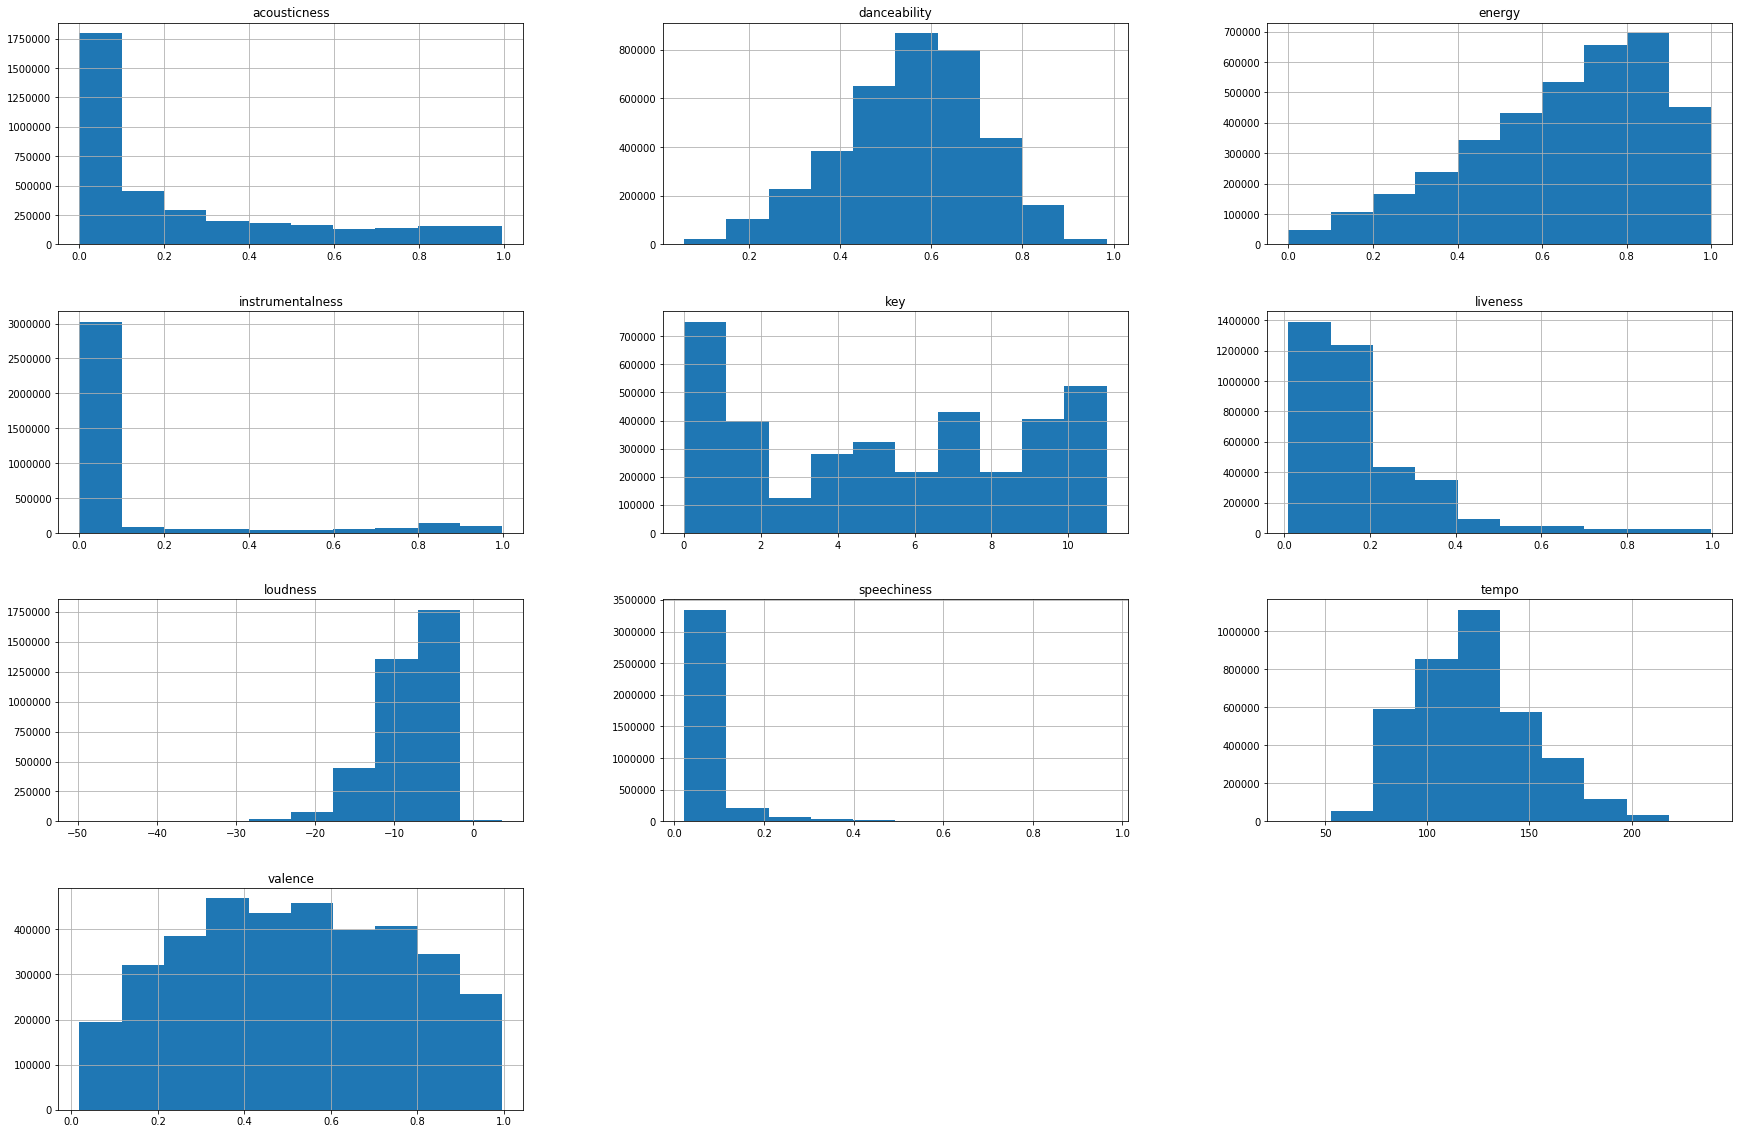

In [0]:
# Create continuous dataset and look at distributions of data
df_mvp_lin = df_mvp.drop(['sentiment','sentiment_score','hashtag','user_id','track_id','artist_id','tweet_lang',
                          'time_zone','mode'], axis=1)
df_mvp_lin.hist(figsize = [30, 20]);

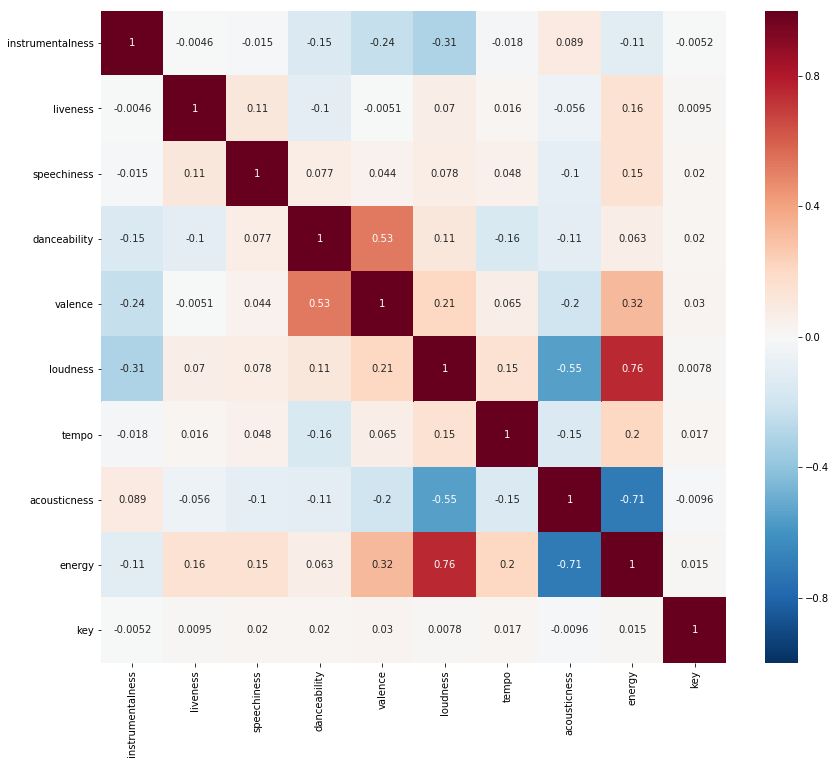

In [0]:
#Create coorelation heatmap and check for multicolinarity
from matplotlib import pyplot as plt
import seaborn as sns

correlation = df_mvp_lin.corr()
plt.figure(figsize=(14, 12))
heatmap = sns.heatmap(correlation, annot=True, linewidths=0, vmin=-1, cmap="RdBu_r")

## Logistic Regression
* Normalize the data prior to fitting the model
* Train-Test Split
* Fit the model
* Predict
* Evaluate

In [0]:
# Define X and y
y = df_mvp['sentiment']
X = df_mvp.drop('sentiment', axis = 1)

In [0]:
# Normalizing the data prior to fitting the model.
x_feats = ['sentiment_score','instrumentalness','liveness','speechiness','danceability',
           'loudness','tempo','acousticness','energy','mode','key','valence']

X = pd.get_dummies(df_mvp[x_feats], drop_first=False)
y = df_mvp.sentiment
X.head()

,sentiment_score,instrumentalness,liveness,speechiness,danceability,loudness,tempo,acousticness,energy,mode,key,valence
0,2.4,0.00000,0.1980,0.1690,0.461,-9.046,143.055,0.1000,0.628,0,4.0,0.502
1,2.4,0.00001,0.0454,0.0451,0.677,-13.237,77.837,0.0313,0.544,0,11.0,0.886
2,0.6,0.00001,0.0454,0.0451,0.677,-13.237,77.837,0.0313,0.544,0,11.0,0.886
3,1.0,0.00001,0.0454,0.0451,0.677,-13.237,77.837,0.0313,0.544,0,11.0,0.886
4,2.4,0.84100,0.1290,0.4770,0.584,-31.865,131.831,0.9270,0.103,0,0.0,0.223


In [0]:
from sklearn.model_selection import train_test_split

# Splitting the data into train and test sets (automatically uses stratified sampling by labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

In [0]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(fit_intercept = True, C=1e12)
model_log = logreg.fit(X_train, y_train)
model_log

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
print(y_train.value_counts())
print(y_test.value_counts())

1    2715538
0      38375
Name: sentiment, dtype: int64
1    905071
0     12900
Name: sentiment, dtype: int64


In [0]:
#Predict against test set using Sigmoid function
y_hat_test = logreg.predict(X_test)
y_hat_train = logreg.predict(X_train)

In [0]:
y_hat_test = logreg.predict_proba(X_test)
y_hat_test[0]

array([5.63490531e-05, 9.99943651e-01])

In [0]:
logreg.predict_proba(X_train)

array([[2.20262793e-05, 9.99977974e-01],
       [8.52465853e-06, 9.99991475e-01],
       [2.54121573e-05, 9.99974588e-01],
       ...,
       [3.38818328e-05, 9.99966118e-01],
       [1.88962724e-05, 9.99981104e-01],
       [5.22750695e-05, 9.99947725e-01]])

In [0]:
# How may times was the classifier correct for the training set?
logreg.score(X_train, y_train)

0.9999771234603272

In [0]:
# How may times was the classifier correct for the test set?
logreg.score(X_test, y_test)

0.9999803915374232

### Model Performance

In [0]:
# Function to calculate the precision
def precision(y_hat, y):
    y_y_hat = list(zip(y, y_hat))
    tp = sum([1 for i in y_y_hat if i[0]==1 and i[1]==1])
    fp = sum([1 for i in y_y_hat if i[0]==0 and i[1]==1])
    return tp/float(tp+fp)

In [0]:
# Function to calculate the recall
def recall(y_hat, y):
    y_y_hat = list(zip(y, y_hat))
    tp = sum([1 for i in y_y_hat if i[0]==1 and i[1]==1])
    fn = sum([1 for i in y_y_hat if i[0]==1 and i[1]==0])
    return tp/float(tp+fn)

In [0]:
# Function to calculate the accuracy
def accuracy(y_hat, y):
    y_y_hat = list(zip(y, y_hat))
    tp = sum([1 for i in y_y_hat if i[0]==1 and i[1]==1])
    tn = sum([1 for i in y_y_hat if i[0]==0 and i[1]==0])
    return (tp+tn)/float(len(y_hat))

In [0]:
# Calculate the precision, recall and accuracy of the classifier.
y_hat_test = logreg.predict(X_test)
y_hat_train = logreg.predict(X_train)

print('Training Precision: ', precision(y_hat_train, y_train))
print('Testing Precision: ', precision(y_hat_test, y_test))
print('\n')

print('Training Recall: ', recall(y_hat_train, y_train))
print('Testing Recall: ', recall(y_hat_test, y_test))
print('\n')

print('Training Accuracy: ', accuracy(y_hat_train, y_train))
print('Testing Accuracy: ', accuracy(y_hat_test, y_test))

Training Precision:  1.0
Testing Precision:  1.0


Training Recall:  0.9999768001773498
Testing Recall:  0.9999801120575071


Training Accuracy:  0.9999771234603272
Testing Accuracy:  0.9999803915374232


In [0]:
#Create a Confusion Matrix
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix:\n',cnf_matrix)

Confusion Matrix:
 [[  38375       0]
 [     63 2715475]]


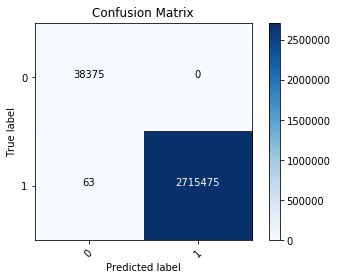

In [0]:
#Plot the Confusion Matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(cnf_matrix,  cmap=plt.cm.Blues) #Create the basic matrix

#Add title and axis labels
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

#Add appropriate axis scales
class_names = set(y) #Get class labels to add to matrix
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

#Add Labels to each cell
thresh = cnf_matrix.max() / 2. #Used for text coloring below
#Here we iterate through the confusion matrix and append labels to our visualization
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

#Add a side bar legend showing colors
plt.colorbar()

In [0]:
# Calculate the false positive rate and true positive rate of the classifier.
from sklearn.metrics import roc_curve, auc

# Calculate the probability scores of each of the datapoints:
y_score = model_log.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

y_train_score = model_log.decision_function(X_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_score)

### ROC Graph
Plot the Receiver Operating Characteristic Curve for both the train and test sets using the false positive rate and true positive rate.

Test AUC: 0.9999999994860996
Train AUC: 0.9999999732652063


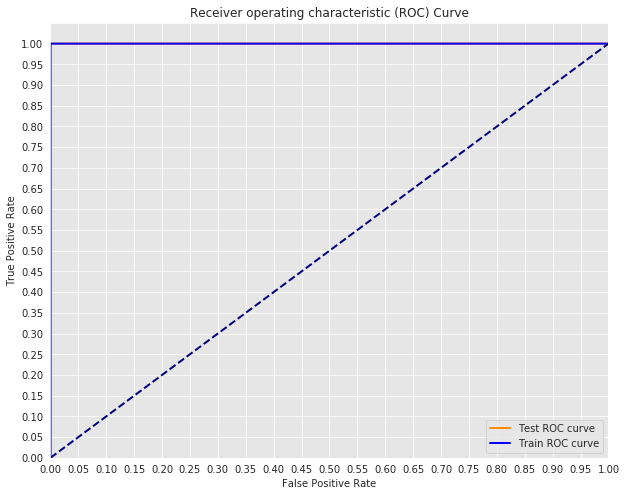

In [0]:
#Seaborn styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

#Test set
plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Test ROC curve')
plt.plot(train_fpr, train_tpr, color='blue',
         lw=lw, label='Train ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
print('Test AUC: {}'.format(auc(fpr, tpr)))
print('Train AUC: {}'.format(auc(train_fpr, train_tpr)))
plt.show()